# **Deep Learning Project**
Done by: <br>
- Ana Farinha | 20211514
- Ana Reis | 20211631
- Beatriz Barreto | 20211547
- Mariana Neto | 20211527


### <font color='#b185db'> Mount drive and import libraries</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import kerastuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow import keras
!pip install keras-tuner
!pip install keras-tuner --upgrade
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from PIL import Image



<ipython-input-2-606e6836dfbb>:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


<br>

### <font color='#b185db'>Import dataset</font>

Importing the dataset as metadata_df.

In [ ]:
metadata_df = pd.read_csv("/content/drive/MyDrive/ProjectDL23_24/HAM10000_metadata.csv")
metadata_df = metadata_df.set_index('image_id')
metadata_df

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...
ISIC_0033084,HAM_0002867,akiec,histo,40.0,male,abdomen
ISIC_0033550,HAM_0002867,akiec,histo,40.0,male,abdomen
ISIC_0033536,HAM_0002867,akiec,histo,40.0,male,abdomen


<br>

## <font color='#b185db'>Preprocessing</font>

In this seccion, the images were resized in order to prevent memory issues. Subsequently, advanced preprocessing techniques were applied to images in the X_train and, also, X_test, namely grayscale conversion and hair removal.


#### <font color='#b185db'>Image</font>

Defining the directories for the training and testing images. These variables will store the paths to the respective image folders. The following codes until the conertion of bgr to rgb, were taken from the pratical class number 15.


In [ ]:
train_images_DIR = "/content/drive/MyDrive/ProjectDL23_24/train"
test_images_DIR = "/content/drive/MyDrive/ProjectDL23_24/test"

The following Python function, `find_extreme_images`, is designed to identify the largest and smallest images within directories. This function takes the directories path as input, iterates through the files in the directory, and compares the sizes of the images. It returns the file path and size (width x height) of both the largest and smallest images found. In this way, we can check if all images have the same shape, in order to introduce them inside of the model.


In [ ]:
# Function to find the largest and smallest images in a directory
def find_extreme_images(directory):
  # Define the variables of smalles and biggest images
  largest_image = None
  smallest_image = None
  largest_size = 0
  smallest_size = float('inf') ## infinit number

  # Iteration loop for each folder to compare the image sizes
  for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    with Image.open(file_path) as img:
      img_size = img.size[0] * img.size[1]
      # overwrite the variables if bigger/smaller
      if img_size > largest_size:
        largest_size = img_size
        largest_image = file_path, img.size
      if img_size < smallest_size:
        smallest_size = img_size
        smallest_image = file_path, img.size

  return largest_image, smallest_image

# Find the largest and smallest images in train and test directories
largest_train_image, smallest_train_image = find_extreme_images(train_images_DIR)
largest_test_image, smallest_test_image = find_extreme_images(test_images_DIR)

print("Largest image in the train directory:")
print("File Path:", largest_train_image[0])
print("Size (Width x Height):", largest_train_image[1])
print("\nSmallest image in the train directory:")
print("File Path:", smallest_train_image[0])
print("Size (Width x Height):", smallest_train_image[1])
print("\nLargest image in the test directory:")
print("File Path:", largest_test_image[0])
print("Size (Width x Height):", largest_test_image[1])
print("\nSmallest image in the test directory:")
print("File Path:", smallest_test_image[0])
print("Size (Width x Height):", smallest_test_image[1])

Largest image in the train directory:
File Path: /content/drive/MyDrive/ProjectDL23_24/train/ISIC_0029682.jpg
Size (Width x Height): (600, 450)

Smallest image in the train directory:
File Path: /content/drive/MyDrive/ProjectDL23_24/train/ISIC_0029682.jpg
Size (Width x Height): (600, 450)

Largest image in the test directory:
File Path: /content/drive/MyDrive/ProjectDL23_24/test/ISIC_0026883.jpg
Size (Width x Height): (600, 450)

Smallest image in the test directory:
File Path: /content/drive/MyDrive/ProjectDL23_24/test/ISIC_0026883.jpg
Size (Width x Height): (600, 450)


From the output above, we can check that all images have the same shape, with width of 600 and height of 450.

<br>

The function `resize_and_create_arrays` loads the images and resizes them to a standardized dimension of 100 x 100 pixels. It also creats arrays to store both the image data (`X`) and their corresponding labels (`y`). This function uses the OpenCV library (`cv2`) for reading and resizing the images.


In [ ]:
def resize_and_create_arrays(directory):
  ## Define the X to store the arrays of images
  X=[]
  ## Define Y to store the labels of the images
  y=[]
  for img in tqdm(os.listdir(directory)):
    path = os.path.join(directory, img)
    # Get label and append to list
    y.append(metadata_df.at[img[:-4], 'dx'])
    # Apply image transformations
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    # Resize because of RAM
    img = cv2.resize(img, (100, 100))
    # Append to list
    X.append(np.array(img))
  # Return X and y
  return X, y

Therefore, using the `resize_and_create_arrays` the image arrays are stored in `X_train`, while the corresponding labels are stored in `y_train`. The same is done with `X_test`. Due to RAM, we had to put the variables with the same name.


In [ ]:
# Resize images and create X and y arrays for train directory
X_train, y_train = resize_and_create_arrays(train_images_DIR)

100%|██████████| 7511/7511 [01:40<00:00, 74.77it/s]


In [ ]:
# Resize images and create X and y arrays for test directory
X_test, y_test = resize_and_create_arrays(test_images_DIR)

100%|██████████| 2504/2504 [00:28<00:00, 86.80it/s] 


The code below converts the list of images array and labels into a NumPy array, in order to be compatible with the neural network model.

In [ ]:
# Convert X and y to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Afterweards, we proceed to print the shapes of the resulting arrays.

In [ ]:
print("Resized images and created X and y arrays.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Resized images and created X and y arrays.
X_train shape: (7511, 100, 100, 3)
y_train shape: (7511,)
X_test shape: (2504, 100, 100, 3)
y_test shape: (2504,)


Each image in the `X_train` and `X_test` arrays, have dimensions of 100 pixels in height, 100 pixels in width, and 3 channels, which indicates that the images are in a rgb format. We can also check that there is 7511 images in the `X_train`, and 2504 images in the `X_test`.

<br>

The following steps will be necessary in order to remove the hair in the images, within the X_train and X_test, which are:

- Convert BGR to RGB;
- Convert RGB to Gray scale
- Hair removal function
- Sharpen the images

#### <font color='#b185db'>Convert BGR to RGB</font>



To facilitate a clearer understanding of the images and enable effective hair removal, we converted the images from the default BGR color space, as used by the OpenCV (cv2) library, to the RGB color space. This conversion allowed us to visualize the original images.

##### <font color='#b185db'>X_train</font>


This for loop will iterate over all images in the X_train, converting all of them to RGB.

In [ ]:
# Converting BGR images into RGB
for i in range(len(X_train)):
    X_train[i] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB)

The following code uses Matplotlib's `imshow` function to display an image from the training set. In this example, the image at index 9 from the `X_train` array is selected and shown using `plt.show()`.

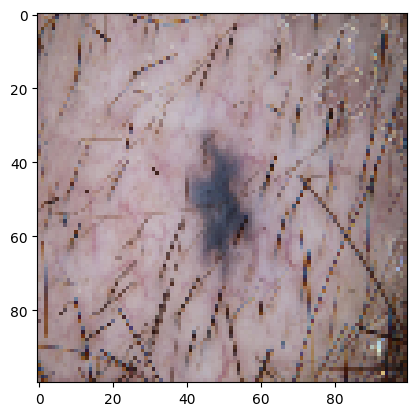

In [ ]:
# Display image at index 9
plt.imshow(X_train[9])

##### <font color='#b185db'>X_test</font>


This for loop will iterate over all images in the X_test, converting all of them to RGB.

In [ ]:
# Converting BGR images into RGB
for i in range(len(X_test)):
    X_test[i] = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB)

The following code uses Matplotlib's `imshow` function to display an image from the test set. In this example, the image at index 9 from the `X_test` array is selected and shown using `plt.show()`.

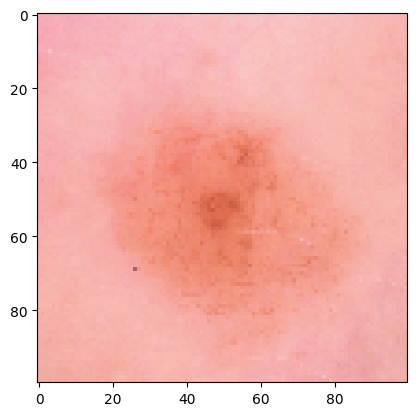

In [ ]:
# Display image at index 9
plt.imshow(X_test[9])

<br>

#### <font color='#b185db'>Grey Scale transformation</font>


To simplify the subsequent hair removal process and focus on the essential features of the images, we converted the RGB images to greyscale.

##### <font color='#b185db'>X_train</font>


The provided code focuses on transforming the RGB images in the training set (`X_train`) into grayscale images. A new NumPy array, `X_train_gray`, is initialized to store the grayscale representations. It converts each image using OpenCV's `cv2.cvtColor` function. The following code was taken from:

Chene, K. (2023, April 25). Python: Converting Colored Images to Grayscale using OpenCV. CopyProgramming. https://copyprogramming.com/howto/open-cv2-converting-color-image-to-grayscale

In [ ]:
X_train_grayscale = np.zeros(X_train.shape[:-1])
for i in range(X_train.shape[0]):
    X_train_grayscale[i] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)

Then, we check if the provided code gave the shape expected.

In [ ]:
X_train_grayscale.shape

(7511, 100, 100)

As you can see, the images are now in gray scale, with a single channel. Using the code below, we can check using Matplotlib's `imshow` function the displayed grayscale image.

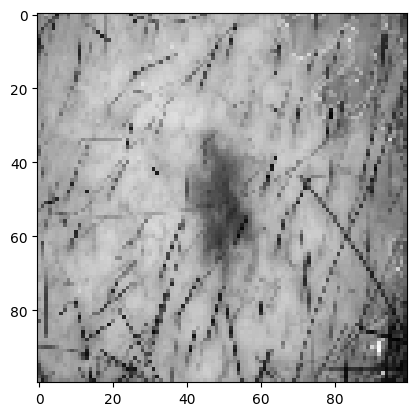

In [ ]:
# Displaying image at index 9
plt.imshow(X_train_grayscale[9], cmap='gray')

##### <font color='#b185db'>X_test</font>


The provided code focuses on transforming the RGB images in the test set (`X_test`) into grayscale images. A new NumPy array, `X_test_gray`, is initialized to store the grayscale representations. It converts each image using OpenCV's `cv2.cvtColor` function.

In [ ]:
X_test_grayscale = np.zeros(X_test.shape[:-1])
for i in range(X_test_grayscale.shape[0]):
    X_test_grayscale[i] = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2GRAY)

Using the code below, we can check using Matplotlib's `imshow` function the displayed grayscale image.

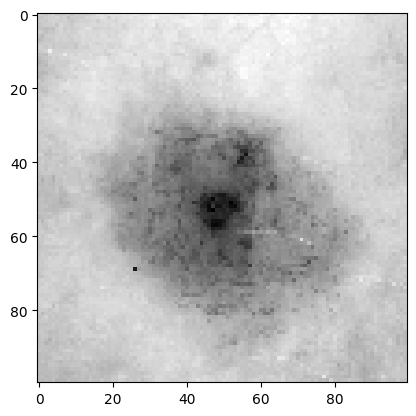

In [ ]:
# Displaying image at index 9
plt.imshow(X_test_grayscale[9], cmap='gray')

<br>

#### <font color='#b185db'>Hair Removal</font>

After converting the images to gray scale, we then proceed to remove the hair. This choise aimed to mitigate the impact of hair in the model's performance. The `hair_removal` function uses a combination of morphological transformations, thresholding, and inpainting.

Steps:
- Morphological transformation: uses the morphological gradient operation (cv2.MORPH_GRADIENT) with a 3x3 rectangular kernel. This operation accentuates the boundaries of the hair in the image;
- Thresholding: applies a threshold (cv2.THRESH_TOZERO) to create a binary mask, in order to highlight where the hair is present in the image;
- Inpainting: uses inpainting (`cv2.inpaint`) to reconstruct the image by filling in the highlighted areas based on surrounding information. The inpainting algorithm, specified as `cv2.INPAINT_TELEA`, helps to interpolate missing regions.

This function will be applied to both X_train and X_test.

In [ ]:
# Function to remove hair
def hair_removal(image):
    # This helps to do hair removal
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Morphological Transformation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)

    # Thresholding
    _, threshold = cv2.threshold(morph, 30, 255, cv2.THRESH_TOZERO)

    # Inpainting
    final_image = cv2.inpaint(image, threshold, 5, cv2.INPAINT_TELEA)

    return final_image

##### <font color='#b185db'>X_train</font>


Using the grey scale images, `X_train_gray`, we applied the function `hair_removal` for all training data.

In [ ]:
X_train_hair_removed = np.zeros_like(X_train_grayscale)
for i in range(X_train_grayscale.shape[0]):
    X_train_hair_removed[i] = hair_removal(X_train_grayscale[i])

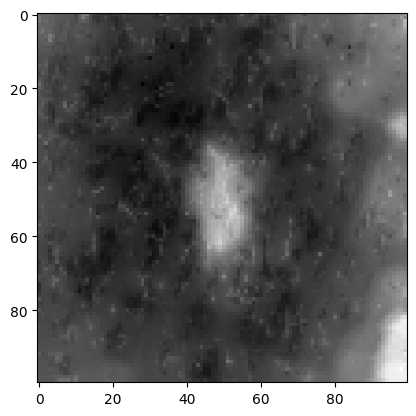

In [ ]:
plt.imshow(X_train_hair_removed[9], cmap='gray')

After checking the results, of the image in index 9, we can see that the hair was successfully removed from the image.

##### <font color='#b185db'>X_test</font>


The same function is applied to the grey scale test data.

In [ ]:
X_test_hair_removed = np.zeros_like(X_test_grayscale)
for i in range(X_test_grayscale.shape[0]):
    X_test_hair_removed[i] = hair_removal(X_test_grayscale[i])

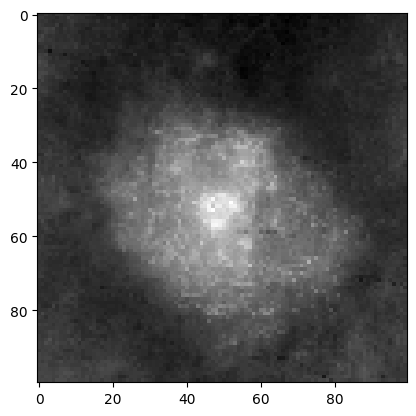

In [ ]:
plt.imshow(X_test_hair_removed[9], cmap='gray')

Following the hair removal process, the preprocessed images were sharpened.

<br>

#### <font color='#b185db'>Sharpening images</font>

Using sharpening, we were able to improve the clarity of the images.

##### <font color='#b185db'>X_train</font>


In [ ]:
# Define the sharpening kernel
kernel_sharpening = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# Initialize an array to store processed images
X_train_sharp = []

# Process each image
for i in range(X_train_hair_removed.shape[0]):
    image = X_train_hair_removed[i]

    # Apply sharpening
    sharpened_image = cv2.filter2D(image, -1, kernel_sharpening)

    # Expand dimensions to match the original shape
    sharpened_image = np.expand_dims(sharpened_image, axis=-1)

    # Store the processed image in the array
    X_train_sharp.append(sharpened_image)

# Convert the list of processed images to a NumPy array
X_train_sharp = np.array(X_train_sharp)

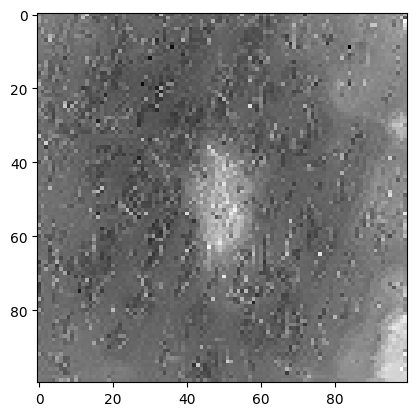

In [ ]:
plt.imshow(X_train_sharp[9], cmap='gray')

In [ ]:
X_train_sharp.shape

(7511, 100, 100, 1)

 In the sharpening for loop, we expanded the dimensions of each sharpened image to ensure compatibility. This expansion involved adding a new dimension to each processed image. By doing this, the shape of the processed image matched the shape of the original images, allowing integration into the model.

##### <font color='#b185db'>X_test</font>


The same process was applied to the testing data

In [ ]:
# Define the sharpening kernel
kernel_sharpening = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# Initialize an array to store processed images
X_test_sharp = []

# Process each image in the dataset
for i in range(X_test_hair_removed.shape[0]):
    image = X_test_hair_removed[i]

    # Apply sharpening
    sharpened_image = cv2.filter2D(image, -1, kernel_sharpening)

    # Expand dimensions to match the original shape
    sharpened_image = np.expand_dims(sharpened_image, axis=-1)

    # Store the processed image in the array
    X_test_sharp.append(sharpened_image)

# Convert the list of processed images to a NumPy array
X_test_sharp = np.array(X_test_sharp)

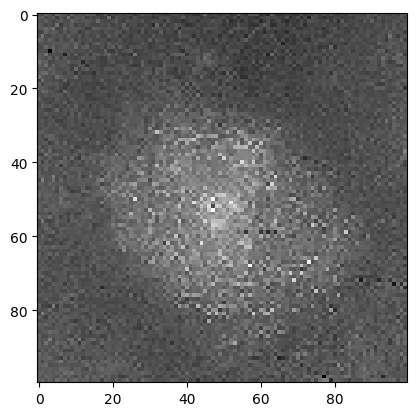

In [ ]:
plt.imshow(X_test_sharp[9], cmap='gray')

<br>

#### <font color='#b185db'>Normalization</font>

The rescaling is other preprocessing step that normalizes pixel values to a range between 0 and 1, which leads to consistent input ranges to models. The reason to divide with 255 is due to the 8-bit representation of pixel values in the images. In an 8-bit image, each pixel can take values ranging from 0 to 255, inclusive. 255 is the maximum number and in this way we can normalize the images to a range between 0 and 1.

In [ ]:
# Rescaling the images in the X_train_hair_removal and X_test_hair_removal
X_train_sharp = X_train_sharp/255
X_test_sharp = X_test_sharp/255

<br>

#### <font color='#b185db'>Label Encoding</font>

Since our labels are categorical we need to convert it to a numerical format, in order to train the model. The following code focuses on converting the categorical labels into a numerical format using the `LabelEncoder` from the scikit-learn library. Using `fit_transform` in y_train and `transform` in the y_test. The reason of the difference is that the `fit_transform` method analyses the unique classes in the training labels (`y_train`) and identifies all distinct labels present in the training set, which determines the mapping between these labels and the numerical codes. Therefore, the `transform` part of the method applies the learned encoding to the actual labels in `y_train`.

In [ ]:
# Convert the labels into a numerical format
labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

<br>

#### <font color='#b185db'>Train-Test split</font>

After images preprocessing was done, the sharpened images (X_train_sharp) are split into training (X_train, y_train) and validation (X_val, y_val) sets using the `train_test_split` function. The split ratio is 80% for training and 20% for validation.

In [ ]:
# Train validation split
X_train, X_val, y_train, y_val=train_test_split(X_train_sharp, y_train, stratify=y_train, test_size=0.2, random_state=42)

The EarlyStopping callback is applied with the parameter patience=3, monitoring the training loss. It allows the training to stop early if there is no improvement in the loss after three consecutive epochs.

In [ ]:
earl_stop= EarlyStopping(monitor="loss", patience=3)


We then proceeded to do a five fold cross validation in the training set. In this way the training data is splitted into five folds while preserving the percentage of samples for each class.

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
151/151 [==============================] - 10s 36ms/step - loss: 1.1076 - accuracy: 0.6633
Epoch 2/20
151/151 [==============================] - 5s 30ms/step - loss: 1.0017 - accuracy: 0.6739
Epoch 3/20
151/151 [==============================] - 4s 29ms/step - loss: 0.9364 - accuracy: 0.6889
Epoch 4/20
151/151 [==============================] - 4s 27ms/step - loss: 0.9013 - accuracy: 0.6966
Epoch 5/20
151/151 [==============================] - 4s 26ms/step - loss: 0.8655 - accuracy: 0.6983
Epoch 6/20
151/151 [==============================] - 4s 26ms/step - loss: 0.8251 - accuracy: 0.7164
Epoch 7/20
151/151 [==============================] - 4s 26ms/step - loss: 0.7556 - accuracy: 0.7364
Epoch 8/20
151/151 [==============================] - 4s 27ms/step - loss: 0.6739 - accuracy: 0.7676
Epoch 9/20
151/151 [==============================] - 4s 26ms/step - loss: 0.5623 - accuracy: 

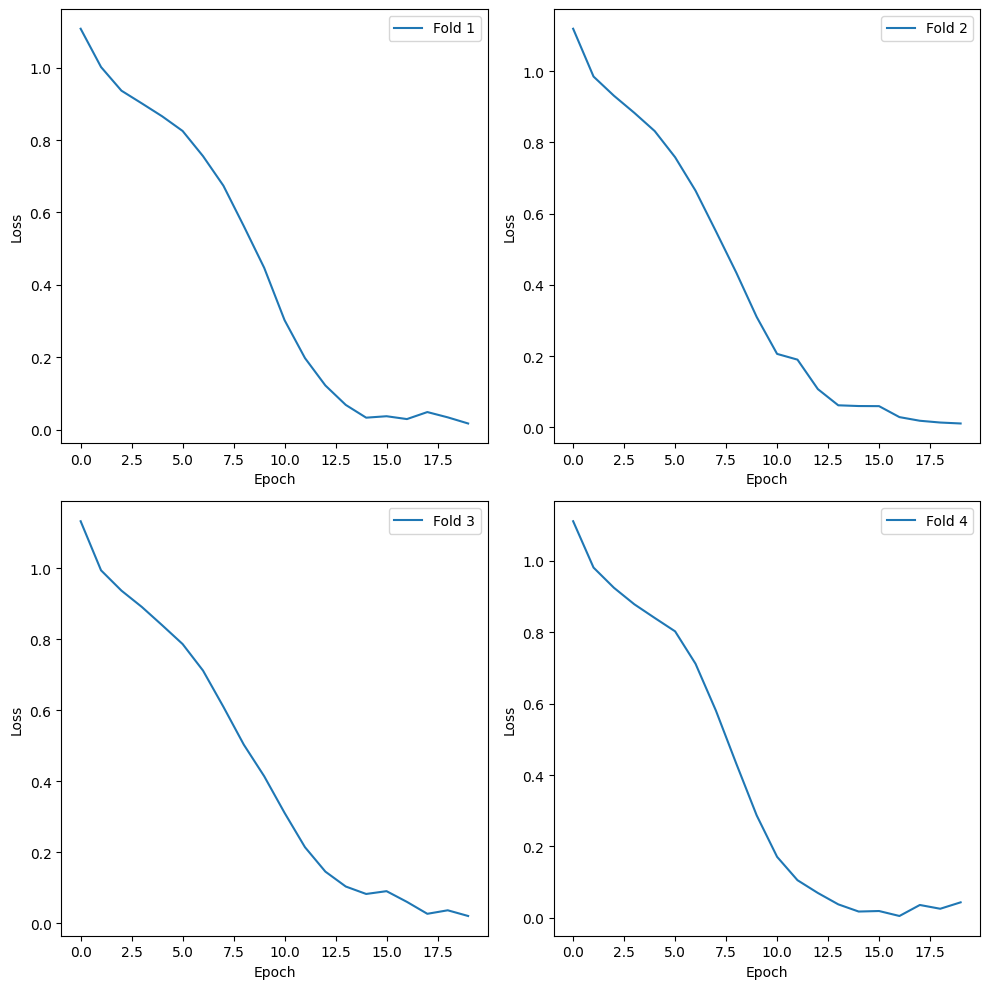

In [ ]:
# Define per-fold score containers
f1_per_fold = []
loss_per_fold = []
history_per_fold = []

# Define the Cross Validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(X_train, y_train):

    # Best model from grid search
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (2, 2), padding='same', activation = 'relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(352, kernel_size = (2, 2), padding='same', activation = 'relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(160, kernel_size = (2, 2), padding='same', activation = 'relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    # model.add(Dense(480, activation='relu'))
    # model.add(Dropout(0.4))
    # model.add(Dense(192, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.1))
    # model.add(Dropout(0.2))
    # model.add(Dense(288, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.3))
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model and store the losses per fold during training
    history = model.fit(X_train[train], y_train[train],
                        batch_size=32,
                        epochs=20,
                        verbose=1,
                        callbacks=[earl_stop])
    history_per_fold.append(history.history['loss'])

    # Generate generalization metrics and evaluate on the k-1 fold
    y_pred = model.predict(X_train_sharp[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_train[test], y_pred_classes, average='weighted')
    scores = model.evaluate(X_train_sharp[test], y_train[test], verbose=1)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; F1 score: {f1}')

    f1_per_fold.append(f1)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

# Plot the loss for each fold in respect to the number of epochs it has trained
# Define the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot the loss for each fold
for fold, ax in enumerate(axes.flat):
    ax.plot(range(len(history_per_fold[fold])), history_per_fold[fold], label=f'Fold {fold+1}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

# Tighten the layout
fig.tight_layout()

# Save the figure as a single image with four subplots
plt.savefig('training_loss_per_fold.png')
plt.show()

In [ ]:
# Provide average scores
print('Score per fold')
for i in range(0, len(f1_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - F1 Score: {f1_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> F1 Score: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 7.3830132484436035 - F1 Score: 0.5021805954436186
------------------------------------------------------------------------
> Fold 2 - Loss: 7.88451623916626 - F1 Score: 0.47967710210388004
------------------------------------------------------------------------
> Fold 3 - Loss: 7.057352542877197 - F1 Score: 0.4829774427507585
------------------------------------------------------------------------
> Fold 4 - Loss: 6.523782730102539 - F1 Score: 0.47921914921902425
------------------------------------------------------------------------
> Fold 5 - Loss: 8.048576354980469 - F1 Score: 0.49208818144513566
------------------------------------------------------------------------
Average scores for all folds:
> Loss: 7.3794482231140135
> F1 Score: 0.4872284941924834 (+- 0.008791205375347316)
------------------------------------------------------------------------


With a f1 score of 0.487, we decided that the best choise was to not apply any pre-processing technique on top of the images.